# Simulated Cube: End-to-End Material-Property Estimation
This demo walks through motion extraction and material-property inference for a simulated cube.
The code here can be used to reproduce the results of Fig. 4 (by varying the number of modes given to the solver), Fig. 6 (by changing the dimensions of the inference cube), and Fig. 7 (by working with a damped cube) from the paper. In this demo, we'll work with the undamped cube named "defect03."
<center>
<br>
<img src="./assets/nmodes_1.png" alt="Reconstructions" width="600"/>
<br>
<em>(Fig. 4) Reconstruction of "defect03" as number of input modes increases.</em>
</center>

### Note: damped cubes
This notebook estimates material properties from *one* video, but for damped objects, multiple videos are usually needed. For the simulated damped cubes, it is recommended to follow the same process used for the real Jello cube, i.e.,
1. **Motion extraction + mode identification for each video:** refer to `demo_real_cube_motion_extraction.ipynb`.
2. **Inference from modes averaged across the videos:** refer to `demo_real_cube_inference.ipynb`.

Animated videos are provided for `damped_defect03` here: https://caltech.box.com/s/52dexrzluqez2797ibngzjms0iw79tzh. For other damped cubes, please
run the `make_comsol_animation.py` script.

## 0. Download Data
The animated video and true material properties can be downloaded here: https://caltech.box.com/s/30rxbleaiq5z9keeoaavj3g0yfsuvodc. Please place the folder in `simulated_data` so that the folder structure looks like:
```
simulated_data/defect03/
    top_front_pluck/
        transient.gif
    true_stiffness.npy
    true_density.npy
```

In [1]:
import time

import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt

import vvt

In [2]:
OBJ_NAME = 'defect03'
SIM_NAME = 'top_front_pluck'
FPS = 2000

N_THREADS = 8  # num. threads to use in multithreaded functions

## 1. Motion Extraction

In [3]:
"""
Read input video.
"""
video_fn = 'simulated_data/%s/%s/transient.gif' % (OBJ_NAME, SIM_NAME)
video_frames = vvt.motion.read_frames(video_fn)

Reading frames: 100%|███████████████████████████████████████████████████████████████| 12000/12000 [00:21<00:00, 571.18it/s]


In [4]:
"""
Extract horizontal and vertical displacement fields,
and then apply amplitude-weighted Gaussian smoothing.
This step may take a couple minutes.
`motion_fields` has the shape (2, T, H, W), where 
`motion_fields[0]` contains the horizontal displacement fields,
and `motion_fields[1]` contains the vertical displacement fields.
"""
t_start, t_end = 50, 6000  # range of frames to extract motion for
reference_frame = video_frames[t_start]
motion_fields = vvt.motion.extract_motion(
    video_frames[t_start:t_end], reference_frame, n_threads=N_THREADS)
motion_fields = vvt.motion.weighted_gaussian_smooth(
    motion_fields, reference_frame, sigma=4, n_threads=N_THREADS)

Running motion extraction in 8 threads...
[Thread 0] 100 / 743 frames processed in 46.7 seconds.
[Thread 0] 200 / 743 frames processed in 46.3 seconds.
[Thread 0] 300 / 743 frames processed in 49.2 seconds.
[Thread 0] 400 / 743 frames processed in 48.3 seconds.
[Thread 0] 500 / 743 frames processed in 54.0 seconds.
[Thread 0] 600 / 743 frames processed in 58.3 seconds.
[Thread 0] 700 / 743 frames processed in 55.5 seconds.
Done! Elapsed time: 0:06:26.425862
Running amplitude-weighted Gaussian smoothing in 8 threads...
[Thread 0] 500 / 743 frames processed in 52.2 seconds.
Done! Elapsed time: 0:01:19.518386


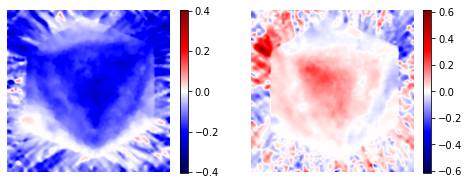

In [5]:
"""
View the displacement field at one frame.
"""
t = 100
plt.figure(figsize=(8, 3))
plt.subplot(121)
vvt.vis.plot_motion_field(motion_fields[0][t])

plt.subplot(122)
vvt.vis.plot_motion_field(motion_fields[1][t])

## 2. Mode Identification

In [6]:
"""
Run 1D FFT on displacement fields.
`fft_dx[i]` contains the FFT coefficients of horizontal motion at FFT bin i.
`fft_dy[i]` contains the FFT coefficients of vertical motion at FFT bin i.
`spectrum` is the power spectrum of horizontal + vertical motion amplitude.
`ffreqs[i]` is the frequency [Hz] of FFT bin i.
"""
max_fft_freq = 50  # max. frequency (in Hz) to consider
fft_dx, fft_dy, spectrum, ffreqs = vvt.modes.get_fft_results(
    motion_fields, FPS, max_fft_freq, n_threads=N_THREADS)
log_spectrum = np.log(spectrum)

Running FFT in 8 threads...
[Thread 0] 5 / 63 rows processed in 9.9 seconds.
[Thread 0] 10 / 63 rows processed in 6.3 seconds.
[Thread 0] 15 / 63 rows processed in 5.9 seconds.
[Thread 0] 20 / 63 rows processed in 5.5 seconds.
[Thread 0] 25 / 63 rows processed in 5.8 seconds.
[Thread 0] 30 / 63 rows processed in 5.5 seconds.
[Thread 0] 35 / 63 rows processed in 5.7 seconds.
[Thread 0] 40 / 63 rows processed in 5.5 seconds.
[Thread 0] 45 / 63 rows processed in 6.4 seconds.
[Thread 0] 50 / 63 rows processed in 6.7 seconds.
[Thread 0] 55 / 63 rows processed in 6.1 seconds.
[Thread 0] 60 / 63 rows processed in 5.4 seconds.
Done! Elapsed time: 0:01:18.044751


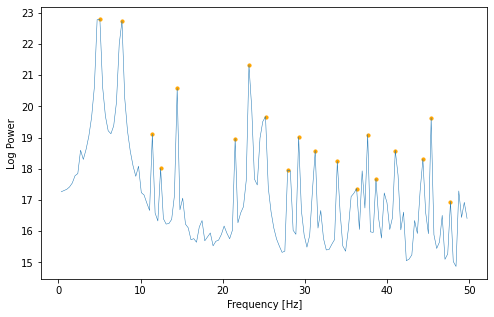

In [7]:
"""
Find peaks in the log-power spectrum of motion amplitude.
"""
max_fft_idx = vvt.utils.find_nearest(ffreqs, max_fft_freq)

# If undamped, recommended prominence is 0.05.
# If damped, recommended prominence is 0.01.
prominence = 0.05
peak_idxs = vvt.modes.find_peak_idxs(log_spectrum[:max_fft_idx], prominence=prominence)

plt.figure(figsize=(8, 5))
plt.plot(ffreqs[1:max_fft_idx], log_spectrum[1:max_fft_idx], linewidth=0.5)
plt.scatter(
    ffreqs[peak_idxs], log_spectrum[peak_idxs],
    color='orange', label='Peaks', s=10)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Log Power')
plt.show()

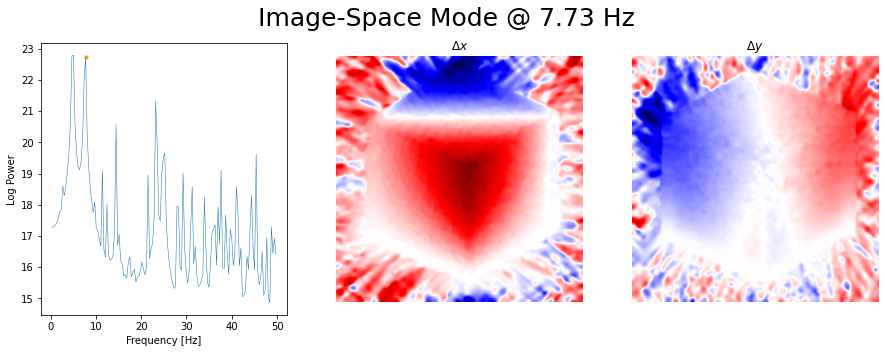

In [8]:
"""
View a specified image-space mode.
"""
fft_idx = peak_idxs[1]

mode_shape_dx = fft_dx[fft_idx].real
mode_shape_dy = fft_dy[fft_idx].real
mode_freq = ffreqs[fft_idx]

fig = plt.figure(figsize=(15, 5))
fig.suptitle('Image-Space Mode @ %.2f Hz' % mode_freq, fontsize=25)

plt.subplot(131)
plt.plot(ffreqs[1:max_fft_idx], log_spectrum[1:max_fft_idx], linewidth=0.5)
plt.scatter(ffreqs[fft_idx], log_spectrum[fft_idx], c='orange', s=10)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Log Power')

plt.subplot(132)
vvt.vis.plot_motion_field(mode_shape_dx, cbar=False)
plt.title('$\Delta$$x$')
plt.axis('off')

plt.subplot(133)
vvt.vis.plot_motion_field(mode_shape_dy, cbar=False)
plt.title('$\Delta$$y$')
plt.axis('off')
plt.show()

## 3. Inference

In [9]:
"""
Define an inference cube model, with specific dimensions, voxel resolution,
homogeneous Poisson's ratio, and mesh element order.
"""
XLEN, YLEN, ZLEN = 0.05, 0.05, 0.05  # dimensions of the cube, in meters
NX, NY, NZ = 8, 8, 8                 # num. voxels in each direction
NU = 0.3                             # homogeneous Poisson's ratio
DEGREE = 1                           # mesh element order (a.k.a. degree)
N_VOX = NX * NY * NZ

cube = vvt.cube.get_cube_model(XLEN, YLEN, ZLEN, NX, NY, NZ, NU, DEGREE)

Element mass mats: 100%|████████████████████████████████████████████████████████████████| 512/512 [00:03<00:00, 129.92it/s]


<IPython.core.display.Javascript object>


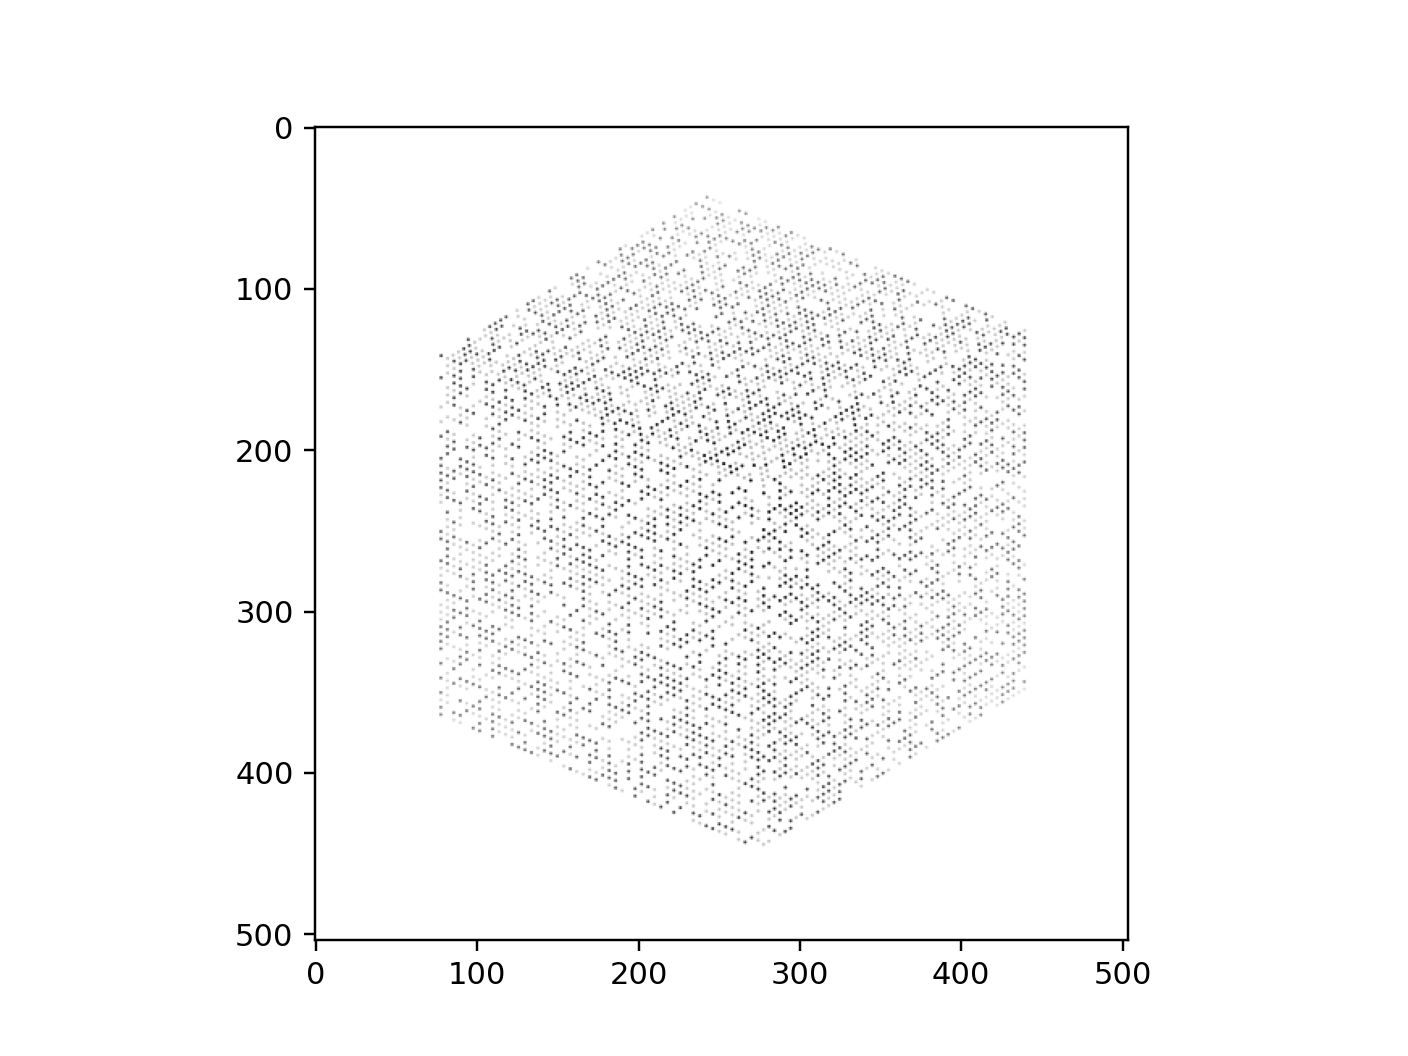

In [10]:
"""
Get the pixel locations of reference mesh points (i.e., the 7 visible corners).
Click the following points in the exact order:
1. bottom left
2. bottom middle
3. bottom right
4. top left back
5. top left front
6. top right back
7. top right front
"""
%matplotlib notebook
clicks = []
vvt.utils.prompt_clicks(reference_frame, clicks, cmap='gray')

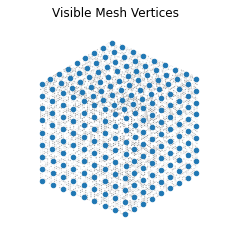

In [11]:
"""
View the positions of the visible mesh points.
"""
plt.close('all')
%matplotlib inline
keypoints = vvt.utils.keypoints_from_clicks(clicks, NX, NY, NZ)

plt.imshow(reference_frame, cmap='gray')
plt.scatter(keypoints[:, 0], keypoints[:, 1], s=20)
plt.axis('off')
plt.title('Visible Mesh Vertices')
plt.show()

In [12]:
"""
Sample image-space modes at keypoints (i.e., visible mesh vertices).
`U_observed` is the full mode matrix, in which only the visible DOFs are
set to the observed (projected) mode shape. Its boundary DOFs are set to 0,
and we normalize each mode to have norm 1.
"""
image_space_modes_dx, image_space_modes_dy = vvt.modes.gather_image_space_modes(
    fft_dx, fft_dy, peak_idxs)
U_observed = vvt.modes.get_observed_modal_data(
    image_space_modes_dx, image_space_modes_dy,
    keypoints, cube.n_dofs, cube.image_space_dofs)
U_observed[cube.bc_dofs] = 0
U_observed = vvt.modes.normalize_modes(U_observed)
freqs_observed = ffreqs[peak_idxs]
eigvals_observed = vvt.utils.freqs_to_eigvals(freqs_observed)

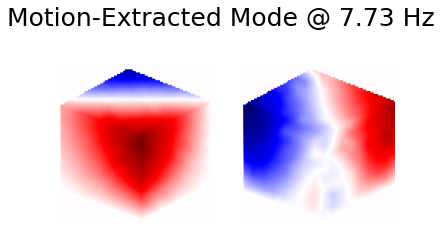

In [13]:
"""
View a specific image-space mode as interpolated between keypoints.
"""
mode_idx = 1
mode_freq = freqs_observed[mode_idx]
mode_2d = U_observed[cube.image_space_dofs, mode_idx].reshape(-1, 3)[:, :2]
mode_dx, mode_dy = vvt.motion.interpolate_2d_motion(keypoints, mode_2d)

fig = plt.figure()
fig.suptitle(
    'Motion-Extracted Mode @ %.2f Hz' % mode_freq,
    fontsize=25)
plt.subplot(121)
vvt.vis.plot_motion_field(mode_dx, cbar=False)

plt.subplot(122)
vvt.vis.plot_motion_field(mode_dy, cbar=False)
plt.show()

In [18]:
"""
Initialize Solver and set the modal data used for material-property estimation.
"""
n_input_modes = 10

proj_mat = vvt.utils.projection_matrix_from_keypoints(cube, keypoints)
solver = vvt.solver.get_solver(cube, proj_mat)

input_modes = np.arange(n_input_modes)
U_input = U_observed[cube.nonbc_dofs, :][:, input_modes]
eigvals_input = eigvals_observed[input_modes]
solver.update_observations(U_input, eigvals_input)
n_modes = solver.k

Gather element mats: 100%|████████████████| 512/512 [00:01<00:00, 484.29it/s]


In [19]:
"""
Set the hyperparameters of the optimization problem that is solved
to estimate the material properties.
"""
w_init = 9000  # initial homog. Young's modulus (in Pa)
v_init = 1270  # initial homog. density (in kg/m3)
eta = 1        # dual-variable update rate
norm_converge_thresh = 1e-3
solver.params['alpha_u'] = 10 if n_modes >= 10 else 1
solver.params['alpha_w'] = 1e-10 / N_VOX
solver.params['alpha_v'] = 1e-7 / N_VOX
solver.params['alpha_e'] = 1
solver.params['scale_reg_type'] = 'mean'
solver.params['alpha_w_mean'] = 1
solver.params['alpha_v_mean'] = 0
solver.params['w_mean'] = w_init
solver.params['v_mean'] = v_init

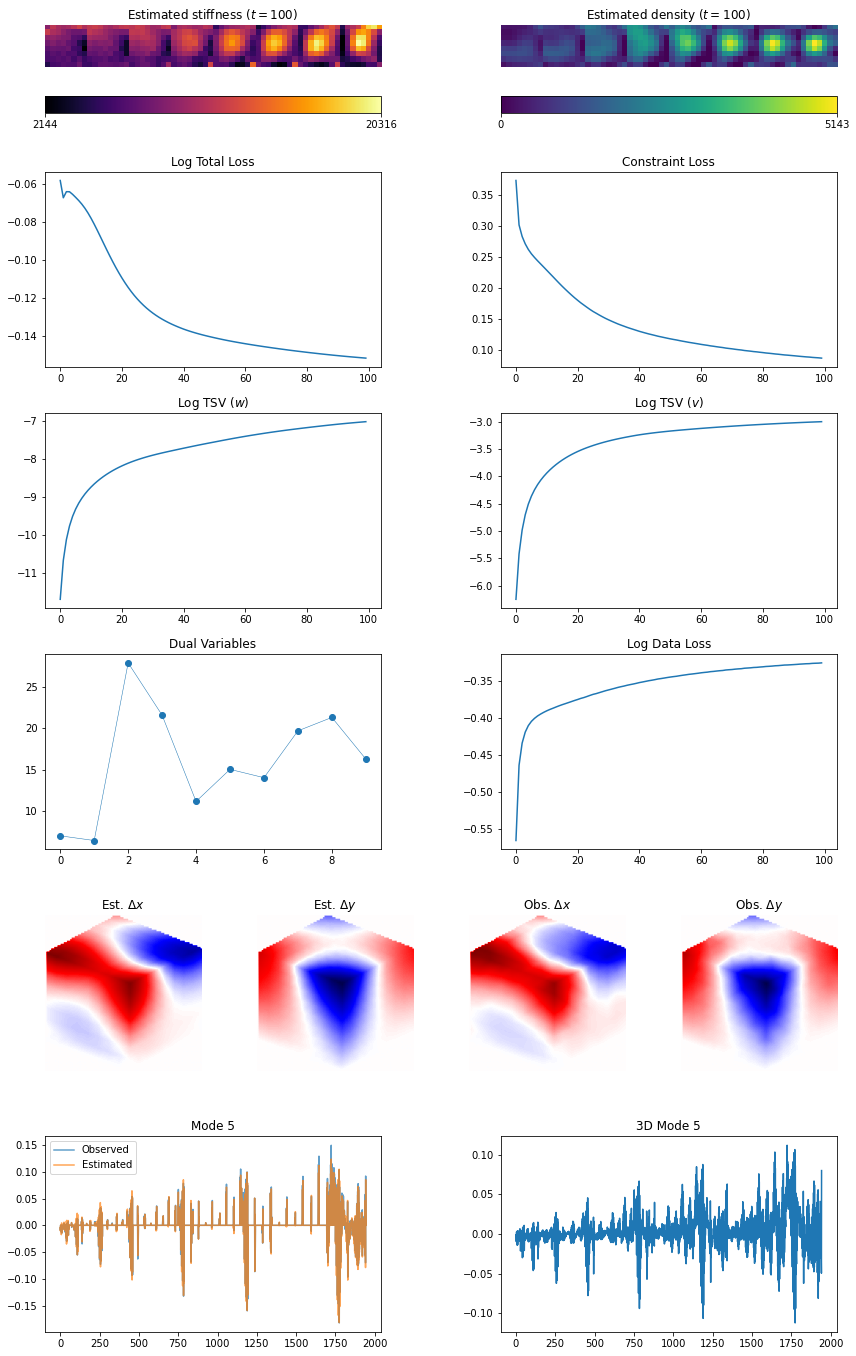

[t=099] 4.101 sec, w residual norm: 0.001145, v residual norm: 0.001399


In [20]:
"""
Run the iterative optimization algorithm, plotting the progress
at each step.
"""
initialize = True

if initialize:
    Ut = solver.Uo.copy()
    evalst = solver.evals_observed.copy()
    wt = np.ones(N_VOX) * w_init
    vt = np.ones(N_VOX) * v_init
    Kt = vvt.utils.weighted_sum(solver.element_stiffness_mats, wt)
    Mt = vvt.utils.weighted_sum(solver.element_mass_mats, vt)
    dual_vars = np.ones(solver.k)
    
    losses_dict = {
        'total': [],
        'constr': [],
        'constr_unw': [],
        'data': [],
        'eigval_data': [],
        'tsv_w': [],
        'tsv_v': [],
        'scale_reg': []
    }
    
Uo_full = vvt.utils.full_mode_matrix(solver.Uo, cube.n_dofs, cube.nonbc_dofs)
w_prev, v_prev = wt, vt
start_t = len(losses_dict['total'])
for t in range(start_t, start_t + 100):
    iter_start = time.time()
    
    # Solve modes.
    Ut = solver.solve_U(Kt, Mt, evalst, dual_vars)
    
    # Solve eigenvalues.
    evalst = solver.solve_evals(Kt, Mt, Ut, dual_vars)
    
    # Update dual variables.
    dual_vars = solver.update_dual_vars(Kt, Mt, Ut, evalst, dual_vars, eta)
    
    # Solve material properties.
    wv = solver.solve_w_v(
        Ut, evalst, dual_vars,enforce_pos=True)
    wt = wv[:solver.n_weights]
    vt = wv[solver.n_weights:]
    Kt = vvt.utils.weighted_sum(solver.element_stiffness_mats, wt)
    Mt = vvt.utils.weighted_sum(solver.element_mass_mats, vt)
    
    # Update losses.
    unw_loss_dict, loss_dict = solver.loss(Ut, evalst, Kt, Mt, wt, vt, dual_vars)
    for loss_term in loss_dict.keys():
        losses_dict[loss_term].append(loss_dict[loss_term])
    losses_dict['constr_unw'].append(unw_loss_dict['constr'])
        
    # Check solution convergence.
    w_residual = wt - w_prev
    v_residual = vt - v_prev
    w_residual_norm = np.linalg.norm(w_residual) / np.linalg.norm(w_prev)
    v_residual_norm = np.linalg.norm(v_residual) / np.linalg.norm(v_prev)
    if w_residual_norm <= norm_converge_thresh and v_residual_norm <= norm_converge_thresh:
        print('Converged! (w residual norm = %.6f, v residual norm = %.6f)'
              % (w_residual_norm, v_residual_norm))
        break
    w_prev, v_prev = wt, vt
    
    # Plot progress.
    Ut_full = vvt.utils.full_mode_matrix(Ut, cube.n_dofs, cube.nonbc_dofs)
    Ut_proj = solver.P @ Ut
    
    fig = plt.figure(figsize=(12, 20))
    
    plt.subplot(621)
    cube.plot_2d(wt, cmap='inferno')
    plt.axis('off')
    plt.title("Estimated stiffness ($t=%d$)" % (t+1))
    
    plt.subplot(622)
    cube.plot_2d(vt, cmap='viridis')
    plt.axis('off')
    plt.title("Estimated density ($t=%d$)" % (t+1))
    
    # Plot losses.
    plt.subplot(623)
    plt.plot(np.log(losses_dict['total']))
    plt.title('Log Total Loss')
    
    plt.subplot(624)
    plt.plot(losses_dict['constr'])
    plt.title('Constraint Loss')
    
    plt.subplot(625)
    plt.plot(np.log(losses_dict['tsv_w']))
    plt.title('Log TSV ($w$)')
    
    plt.subplot(626)
    plt.plot(np.log(losses_dict['tsv_v']))
    plt.title('Log TSV ($v$)')
    
    plt.subplot(627)
    plt.plot(dual_vars, linewidth=0.5)
    plt.scatter(np.arange(solver.k), dual_vars)
    plt.title('Dual Variables')
    
    ax = fig.add_subplot(6, 2, 8)
    ax.plot(np.log(losses_dict['data']))
    ax.set_title('Log Data Loss')

    # Visualize random mode.
    i = np.random.randint(0, solver.k)
    
    # Estimated mode:
    est_mode_3d = Ut_full[cube.image_space_dofs, i].reshape(-1, 3)
    est_mode_dx, est_mode_dy = vvt.motion.project_and_interpolate_motion(
        keypoints, est_mode_3d, proj_mat)
    
    ax = fig.add_subplot(6, 4, 17)
    vvt.vis.plot_motion_field(est_mode_dx, fig=fig, ax=ax, cbar=False)
    ax.set_title('Est. $\Delta$$x$')
    
    ax = fig.add_subplot(6, 4, 18)
    vvt.vis.plot_motion_field(est_mode_dy, fig=fig, ax=ax, cbar=False)
    ax.set_title('Est. $\Delta$$y$')
    
    # Observed mode:
    obs_mode_2d = Uo_full[cube.image_space_dofs, i].reshape(-1, 3)[:, :2]
    obs_mode_dx, obs_mode_dy = vvt.motion.interpolate_2d_motion(
        keypoints, obs_mode_2d)
    
    ax = fig.add_subplot(6, 4, 19)
    vvt.vis.plot_motion_field(obs_mode_dx, fig=fig, ax=ax, cbar=False)
    ax.set_title('Obs. $\Delta$$x$')
    
    ax = fig.add_subplot(6, 4, 20)
    vvt.vis.plot_motion_field(obs_mode_dy, fig=fig, ax=ax, cbar=False)
    ax.set_title('Obs. $\Delta$$y$')
    
    # 1d mode comparison:
    ax = fig.add_subplot(6, 2, 11)
    ax.plot(solver.Uo[:, i], alpha=0.7, label='Observed')
    ax.plot(Ut_proj[:, i], alpha=0.7, label='Estimated')
    ax.legend()
    ax.set_title('Mode %d' % i)
    
    # 3d mode:
    ax = fig.add_subplot(6, 2, 12)
    ax.plot(Ut[:,i] / np.linalg.norm(Ut[:,i]))
    ax.set_title('3D Mode %d' % i)
    
    plt.tight_layout()
    ipd.clear_output(wait=True)
    ipd.display(plt.gcf())
    plt.close('all')
    
    print('[t=%03d] %.3f sec, w residual norm: %.6f, v residual norm: %.6f'
          % (t, time.time() - iter_start, w_residual_norm, v_residual_norm))

### Compare results to the true material properties

In [21]:
"""
Set up the forward Cube model, and load the true material properties.
"""
# Forward model uses a 10x10x10 hexahedral mesh.
cube_forward = vvt.cube.get_cube_model(
    XLEN, YLEN, ZLEN, 10, 10, 10, NU, DEGREE)

# Load true properties.
true_w = np.load('simulated_data/%s/true_stiffness.npy' % OBJ_NAME)
true_v = np.load('simulated_data/%s/true_density.npy' % OBJ_NAME)

Element mass mats: 100%|████████████████| 1000/1000 [00:09<00:00, 110.10it/s]


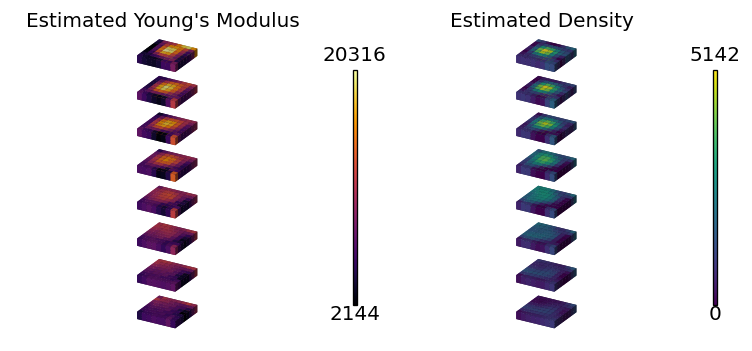

In [22]:
"""
View the estimated stiffness and density values.
"""
fig = plt.figure(constrained_layout=True, dpi=120)

ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.set_proj_type('ortho')
ax.set_title("Estimated Young's Modulus")
vvt.vis.plot_3d_cube(cube, wt, cmap='inferno', fig=fig, ax=ax)

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.set_proj_type('ortho')
ax.set_title("Estimated Density")
vvt.vis.plot_3d_cube(cube, vt, cmap='viridis', fig=fig, ax=ax)

plt.show()

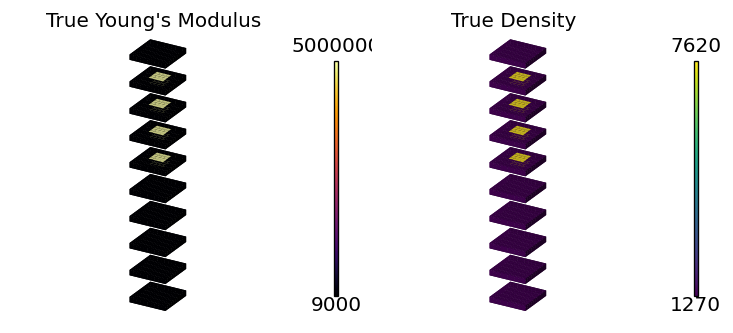

In [23]:
"""
View the true stiffness and density values.
"""
fig = plt.figure(constrained_layout=True, dpi=120)

ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.set_proj_type('ortho')
ax.set_title("True Young's Modulus")
vvt.vis.plot_3d_cube(cube_forward, true_w, cmap='inferno', fig=fig, ax=ax)

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.set_proj_type('ortho')
ax.set_title("True Density")
vvt.vis.plot_3d_cube(cube_forward, true_v, cmap='viridis', fig=fig, ax=ax)
plt.show()